In [1]:
import sys
sys.path.insert(0, 'C:/Udvikler/Speciale/ThesisCode')

from utils import * 
import pandas as pd
from RFQAgent import RFQAgent, DataTransformer
import numpy as np
from model_evaluation.RFQModelEval import RFQModelEval
from model_evaluation import eval_utilities as eval_utils
import itertools

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#Not to make the kernel crash
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
features = ["bpv_risk","DealersInCompetition", "BookName",  "AllQMeanMid"]
#"inventoryRisk",

# Read the CSV file into a pandas DataFrame
file_path = "../data/data_inventory_risk.csv"
df = pd.read_csv(file_path)

#Set seed to replicate results
np.random.seed(41)

# Datetime format
df["TradeTime"] = pd.to_datetime(df["TradeTime"], format="%m/%d/%Y %H:%M:%S")

#Split into train and test set  
train_df, val_df = split_data(df, 0.9)



### Iterate through feature, learning algorithms, number of bins and reward function combinations

In [4]:

all_features = [
    ["bpv_risk", "Side", "BookName", "AllQMeanMid", "Duration", "Amount"],
    #["bpv_risk", "Side", "BookName",  "AllQMeanMid", "Duration", "Price_Diff", "FirmAccount", "Amount"],
    ["inventoryRisk", "Side", "BookName",  "AllQMeanMid", "Duration", "Amount"],
    #["inventoryRisk", "Side", "BookName",  "AllQMeanMid", "Duration", "Price_Diff", "FirmAccount", "Amount"],
]

all_reward_functions = [
    risk_PnL_reward,
    inventory_PnL_reward
]

learning_algorithms = [
    'QL',
    'DQL', 
]

metrics = ["dealerHitRate", "mlHitRate", "MLWinShare", "mlDistToCoverMean", "mlDistToCoverStd", "dealerDistToCoverMean", 
           "meanMLProfit", "meanDealerProfit", "meanRLReward", "dealerD2TargetMean", "MLD2TargetMean", "MLD2TargetStd", "meanMLSharpeRatio",
           "meanDealerSharpeRatioNoNeg", "meanDealerSharpeRatio",  "DealerNetInventoryDiff", "MLNetInventoryDiff"]

# Convert each list of features to a single concatenated string
all_features_str = [",".join(features) for features in all_features]  # Join list of strings with commas

# Create a MultiIndex for the DataFrame using the combinations of parameters
index = pd.MultiIndex.from_tuples(
    [(features, reward_function.__name__, learning_algorithm)
     for features, reward_function, learning_algorithm in 
     itertools.product(all_features_str, all_reward_functions, learning_algorithms)
     if (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
         ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward"))],
    names=["Features", "Reward Function", "Learning Algorithm"]
)


# Initialize an empty DataFrame with the MultiIndex
results_df = pd.DataFrame(columns=metrics, index=index)

# Iterate over all combinations and collect results
for features, reward_function, learning_algorithm in itertools.product(all_features, all_reward_functions, learning_algorithms):
    
    # Apply the condition to skip unwanted combinations
    if ("bpv_risk" in features and reward_function.__name__ == "inventory_PnL_reward") or \
       ("inventoryRisk" in features and reward_function.__name__ == "risk_PnL_reward"):
        continue  
    

    # Convert features list to a single string
    features_key = ",".join(features)  # Join list of strings with commas
    key = (features_key, reward_function.__name__, learning_algorithm)
    
    print(key)
    
    opponent_actions = learning_algorithm in ["QL_MarkovGame", "double_QL_MarkovGame"]
    
    # Perform the experiment (replace with your actual code)
    data_transformer = DataTransformer(
        input_features=features, lower_spread_limit=-0.005, upper_spread_limit=0.15, num_bins=4,
        discretize_method="number", reward_function=reward_function, opponent_actions=opponent_actions,
        vectorize_next_state=False, reward_terms=False)
    
    agent = RFQAgent(data_transformer=data_transformer)
    agent.train(train_df.copy(), algorithm=learning_algorithm)

    modelEvaluator = RFQModelEval(agent)
    modelPerformance = modelEvaluator.eval(val_df.copy(), algorithm=learning_algorithm, print_post_trade=False, 
                                           print_violin_plot=False, random_policy=False)
    

    # Collect and store the relevant metrics
    results_df.loc[key] = modelPerformance[metrics]  # Example of storing mean values

# Display the results DataFrame
print(results_df)

                                        

('bpv_risk,Side,BookName,AllQMeanMid,Duration,Amount', 'risk_PnL_reward', 'QL')
number of different states in dataset: 653,
size of statespace: 1024,
state coverage by trajectory: 0.6377
most frequent action:  26
Total unique states in test data: 250
Number of unseen states in test data: 14
Proportion of unseen states: 0.056
Desired HR: 22.888283378746596 

('bpv_risk,Side,BookName,AllQMeanMid,Duration,Amount', 'risk_PnL_reward', 'DQL')
number of different states in dataset: 653,
size of statespace: 1024,
state coverage by trajectory: 0.6377
most frequent action:  26
Total unique states in test data: 250
Number of unseen states in test data: 14
Proportion of unseen states: 0.056
Desired HR: 22.888283378746596 

('inventoryRisk,Side,BookName,AllQMeanMid,Duration,Amount', 'inventory_PnL_reward', 'QL')
number of different states in dataset: 437,
size of statespace: 1024,
state coverage by trajectory: 0.4268
most frequent action:  26
Total unique states in test data: 187
Number of unseen s

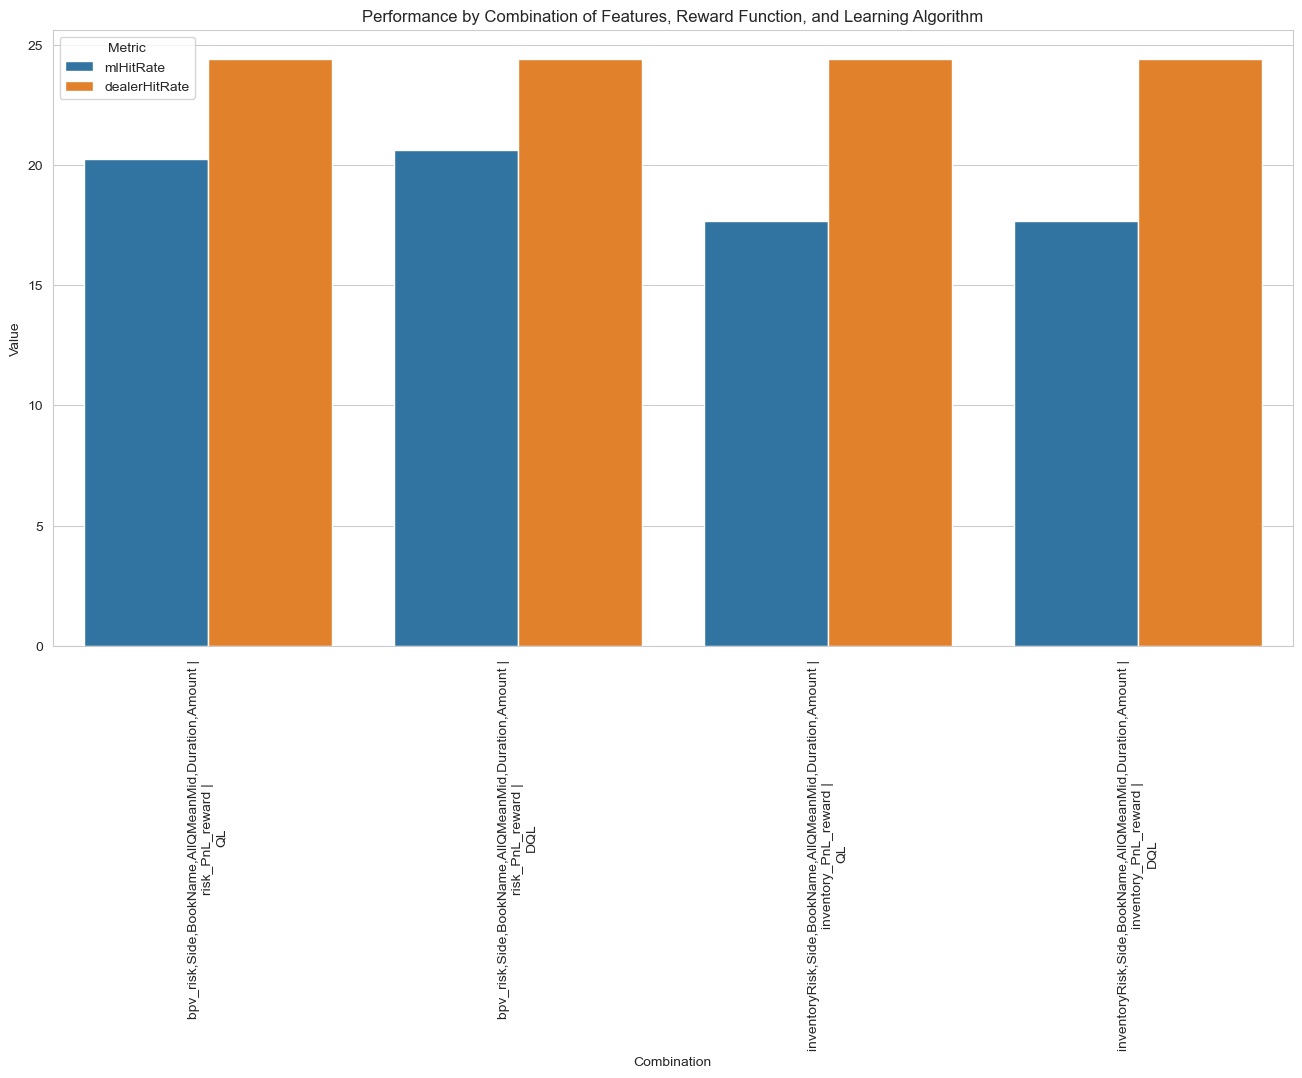

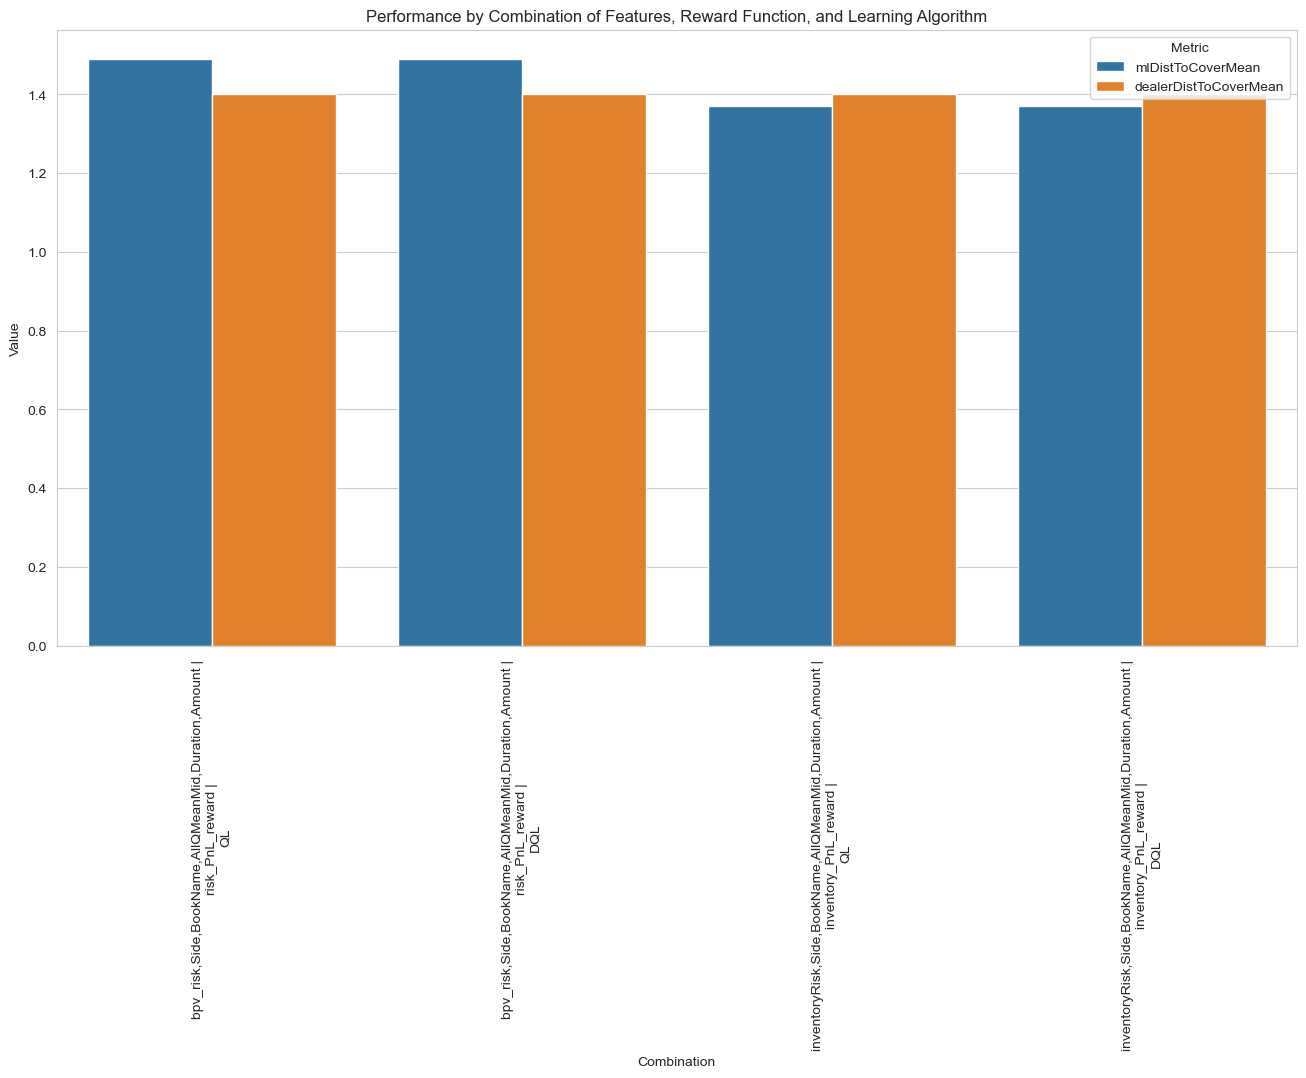

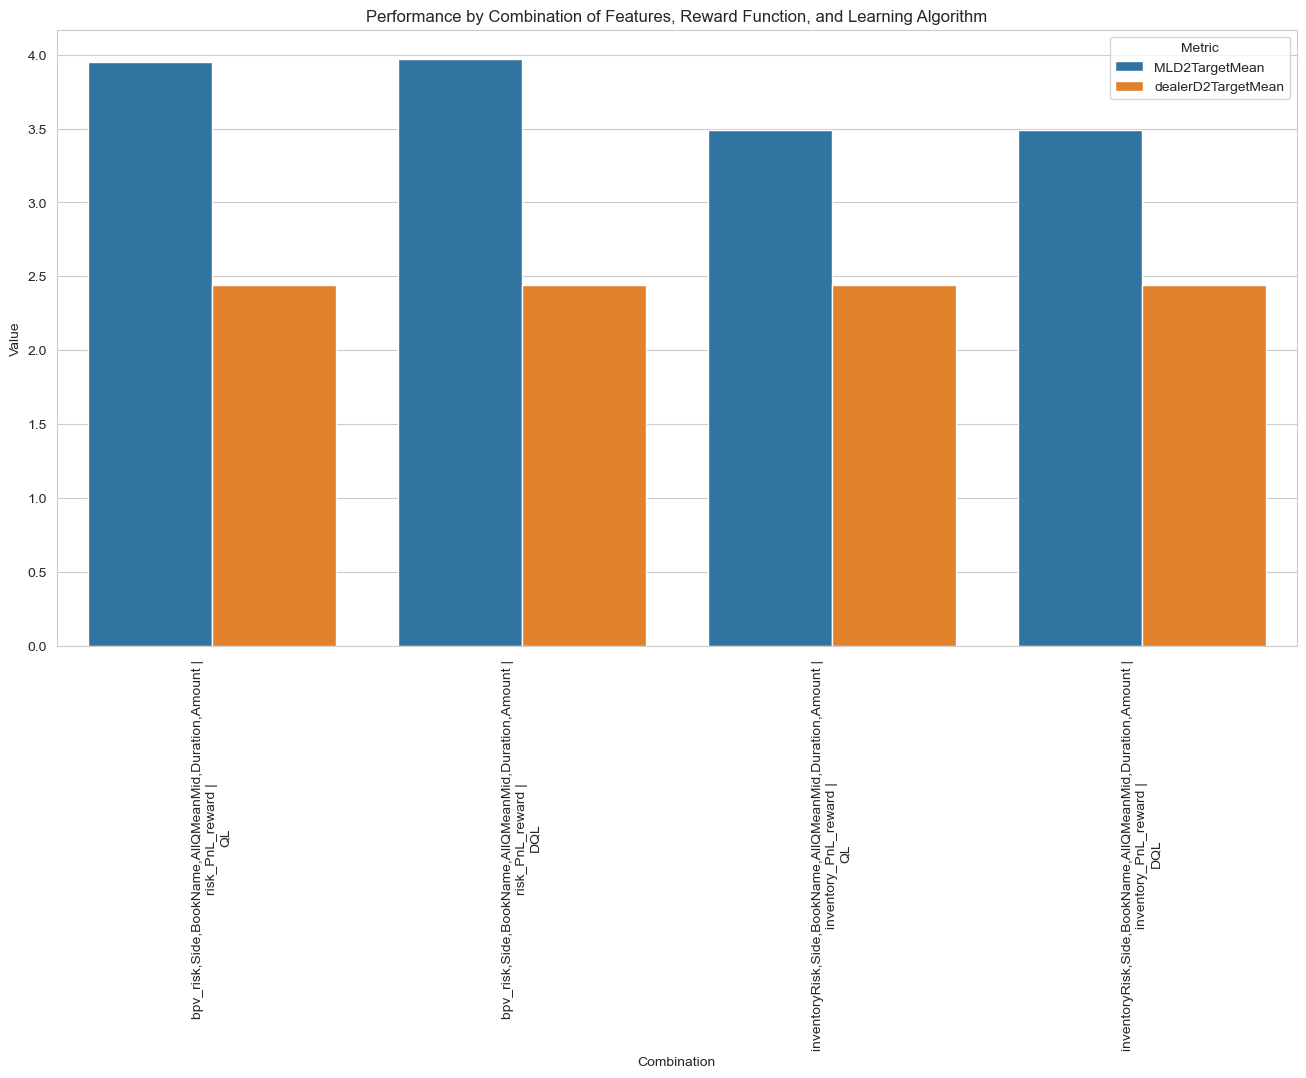

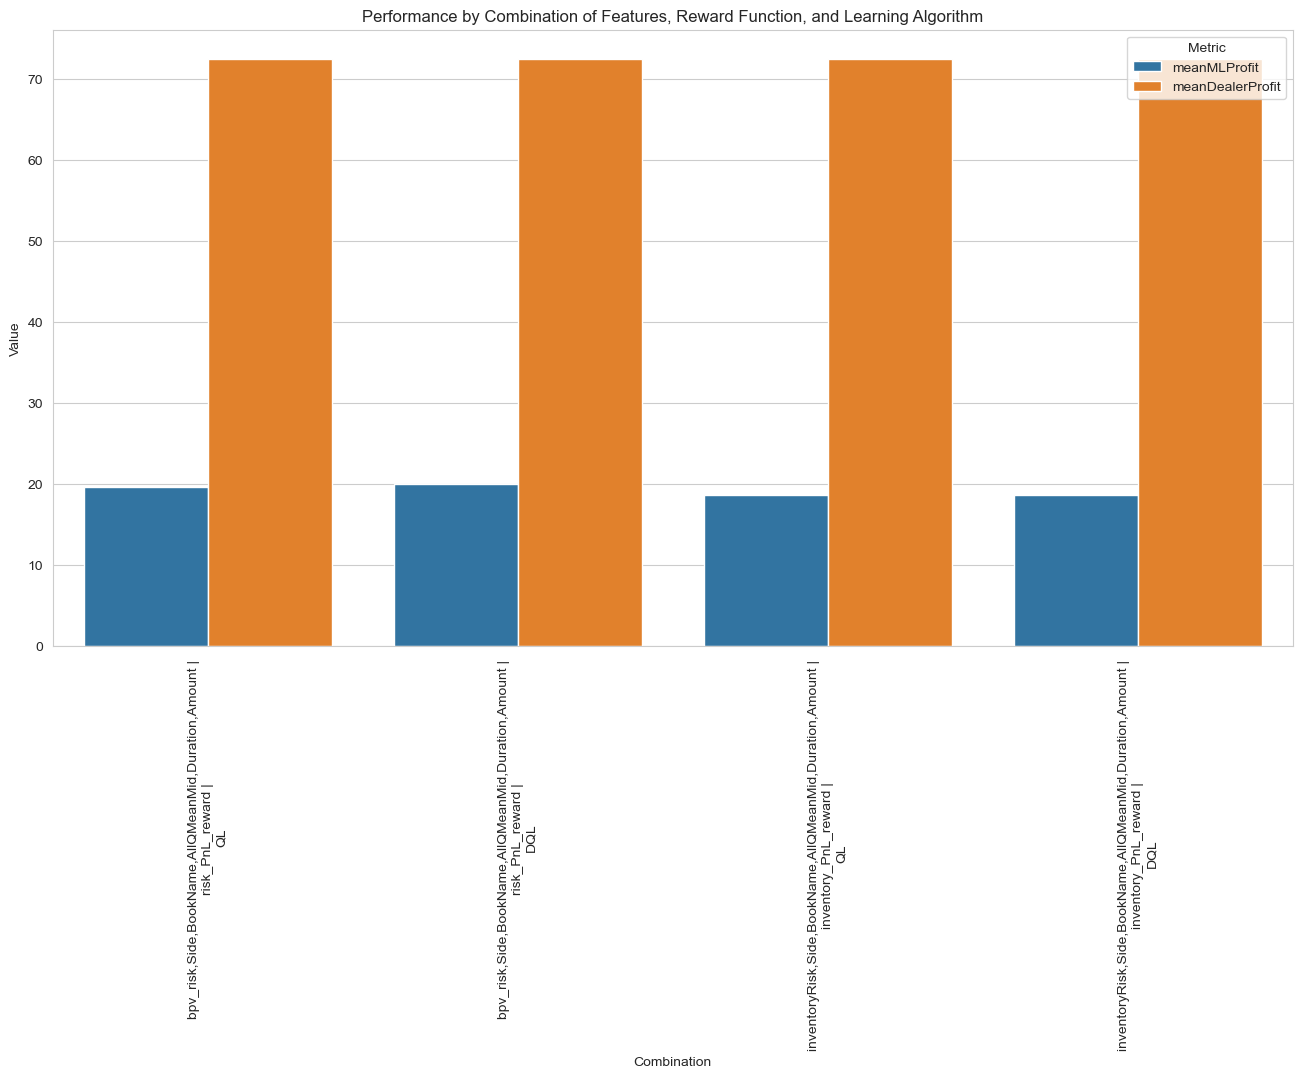

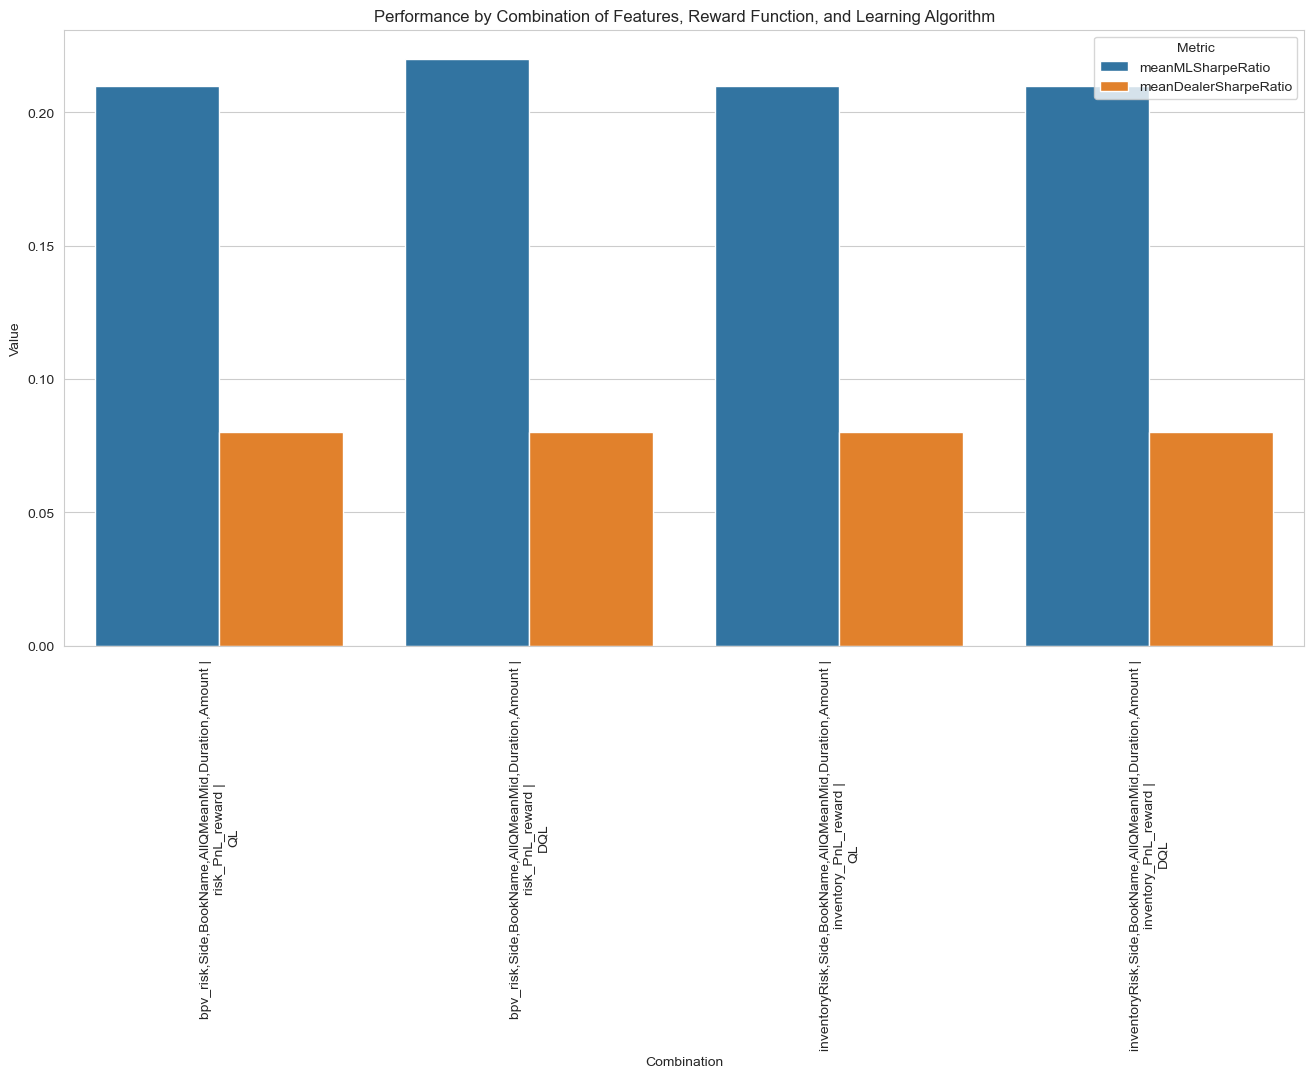

In [5]:
eval_utils.visualize_trader_vs_ML_metrics(results_df=results_df.copy())


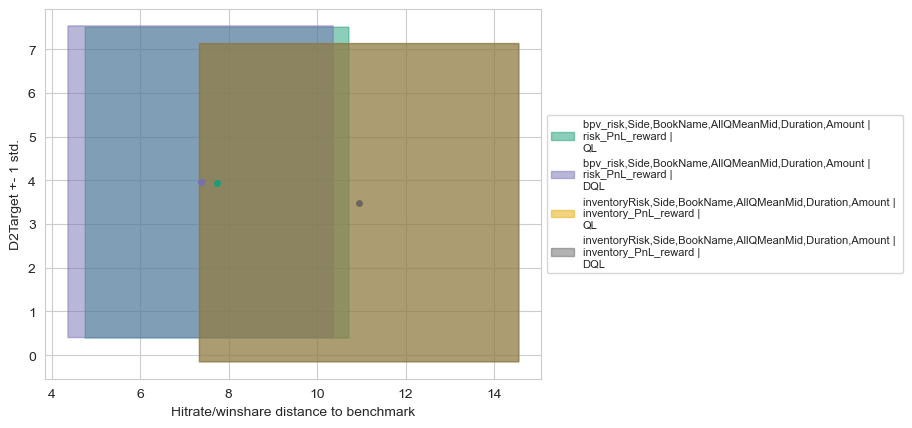

In [6]:
eval_utils.convex_hull(results_df.copy(), distance_measure="Target")